In [2]:
import collections
import os
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import eofs.xarray
import sklearn.cluster
import sklearn.metrics


In [3]:
k06 = xr.open_mfdataset('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_*100to400*.nc') # before: 

In [4]:
k06

<xarray.Dataset> Size: 4GB
Dimensions:              (time: 30436, lat: 91, lon: 360)
Coordinates:
    plev                 int64 8B 100
  * lon                  (lon) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * lat                  (lat) float32 364B 0.0 1.0 2.0 3.0 ... 88.0 89.0 90.0
  * time                 (time) datetime64[ns] 243kB 1940-01-01 ... 2023-04-30
Data variables:
    weighted_average_ws  (time, lat, lon) float32 4GB dask.array<chunksize=(6940, 91, 360), meta=np.ndarray>

In [5]:
# zg = xr.open_dataset('/home/thomaskeel/Dev/Climate Data/ERA-5/era5_zg_79to23.nc')

In [6]:
# zg = zg.rename({'longitude':'lon', 'latitude':'lat', 'z':'z'})
# zg['lon'] = (zg['lon'] + 360) % 360

In [7]:
# zg = zg.sortby('lon')

### normalise data

In [8]:
KOCH_WS_MONTH_MEAN = k06['weighted_average_ws'].groupby('time.month').mean('time')

In [9]:
# ZG_MONTH_MEAN = zg['z'].groupby('time.month').mean('time')

In [10]:
def normalise_data(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())
    

def get_month_anom(row):
    row_month_anom = row - KOCH_WS_MONTH_MEAN.sel(month=row.time.dt.month)
    return row_month_anom

def get_month_anom_zg(row):
    row_month_anom = row - ZG_MONTH_MEAN.sel(month=row.time.dt.month)
    return row_month_anom

In [11]:
# zg.load()

In [12]:
%%time
# zg['z_anom'] = zg['z'].groupby('time').apply(get_month_anom_zg)

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 3.58 μs


In [13]:
%%time
k06['weighted_average_ws'].load();

CPU times: user 555 ms, sys: 10.1 s, total: 10.7 s
Wall time: 11 s


In [14]:
%%time
if os.path.exists('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_jet_events_norm_40to23Mar_upperlevs.nc'):
    print('loading norm data')
    k06['jet_events_ws_norm'] = xr.open_dataarray('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_jet_events_norm_40to23Mar_upperlevs.nc')
else:
    print('making norm data')
    k06['jet_events_ws_norm'] = k06['weighted_average_ws'].groupby('time').apply(get_month_anom)

loading norm data
CPU times: user 9.35 ms, sys: 8.91 ms, total: 18.3 ms
Wall time: 18.9 ms


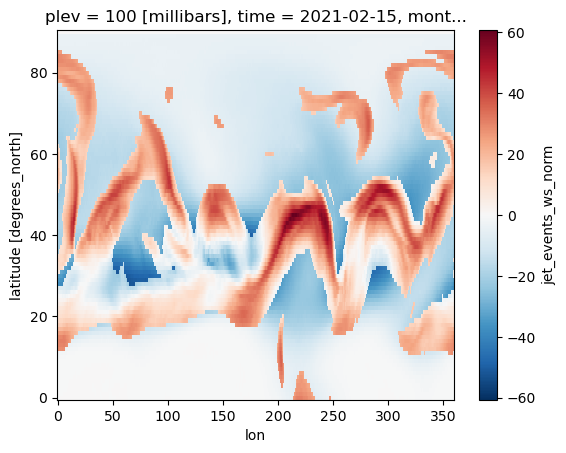

In [15]:
k06['jet_events_ws_norm'].sel(time="2021-02-15").plot()

# load extreme ('persistent') cold data

In [17]:
extreme_cold_persist_thresh = xr.open_dataset('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/input_preparation/outputs/ar6_3daypersist_extreme_cold_detrend_95thpercthresh_q01.nc')

In [18]:
extreme_cold_persist_thresh['cold_air_event_CNA'].to_pandas().value_counts()

cold_air_event_CNA
0    29525
1      910
Name: count, dtype: int64

In [19]:
extreme_cold_persist_thresh.sel(time="2021-02")['cold_air_event_stacked'].load()

<xarray.DataArray 'cold_air_event_stacked' (ar6_region: 3, time: 28)> Size: 672B
array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])
Coordinates:
  * time       (time) datetime64[ns] 224B 2021-02-01 2021-02-02 ... 2021-02-28
    dayofyear  (time) int64 224B 32 33 34 35 36 37 38 ... 53 54 55 56 57 58 59
    quantile   float64 8B 0.01
Dimensions without coordinates: ar6_region

# Select one cold event type

In [20]:
coldairevent_code_to_lookat = '001'

In [21]:
onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == coldairevent_code_to_lookat)\
                                            ).dropna(dim='time')
onetype_coldair_event

<xarray.Dataset> Size: 66kB
Dimensions:                          (time: 630, ar6_region: 3, lon: 91, lat: 41)
Coordinates:
  * lon                              (lon) float32 364B -130.0 -129.0 ... -40.0
  * lat                              (lat) float32 164B 20.0 21.0 ... 59.0 60.0
  * time                             (time) datetime64[ns] 5kB 1940-01-28 ......
    dayofyear                        (time) int64 5kB 28 83 105 ... 109 35 99
    quantile                         float64 8B 0.01
Dimensions without coordinates: ar6_region
Data variables:
    wna_perc_coverage                (time) float64 5kB 0.0 0.0 0.0 ... 0.0 0.0
    cna_perc_coverage                (time) float64 5kB 5.243 10.11 ... 0.0 0.0
    ena_perc_coverage                (time) float64 5kB 22.09 15.99 ... 9.012
    cold_air_event_WNA               (time) float64 5kB 0.0 0.0 0.0 ... 0.0 0.0
    cold_air_event_CNA               (time) float64 5kB 0.0 0.0 0.0 ... 0.0 0.0
    cold_air_event_ENA               (time) float64 5kB 1.0 1.0 1.0 ... 1.0 1.0
    cold_air_event_stacked           (ar6_region, time) float64 15kB 0.0 ... 1.0
    cold_air_event_stacked_names     (time) object 5kB '001' '001' ... '001'
    cold_air_event_stacked_codified  (time) float64 5kB 1.0 1.0 1.0 ... 1.0 1.0

In [22]:
onetype_coldair_event

<xarray.Dataset> Size: 66kB
Dimensions:                          (time: 630, ar6_region: 3, lon: 91, lat: 41)
Coordinates:
  * lon                              (lon) float32 364B -130.0 -129.0 ... -40.0
  * lat                              (lat) float32 164B 20.0 21.0 ... 59.0 60.0
  * time                             (time) datetime64[ns] 5kB 1940-01-28 ......
    dayofyear                        (time) int64 5kB 28 83 105 ... 109 35 99
    quantile                         float64 8B 0.01
Dimensions without coordinates: ar6_region
Data variables:
    wna_perc_coverage                (time) float64 5kB 0.0 0.0 0.0 ... 0.0 0.0
    cna_perc_coverage                (time) float64 5kB 5.243 10.11 ... 0.0 0.0
    ena_perc_coverage                (time) float64 5kB 22.09 15.99 ... 9.012
    cold_air_event_WNA               (time) float64 5kB 0.0 0.0 0.0 ... 0.0 0.0
    cold_air_event_CNA               (time) float64 5kB 0.0 0.0 0.0 ... 0.0 0.0
    cold_air_event_ENA               (time) float64 5kB 1.0 1.0 1.0 ... 1.0 1.0
    cold_air_event_stacked           (ar6_region, time) float64 15kB 0.0 ... 1.0
    cold_air_event_stacked_names     (time) object 5kB '001' '001' ... '001'
    cold_air_event_stacked_codified  (time) float64 5kB 1.0 1.0 1.0 ... 1.0 1.0

In [23]:
onetype_coldair_event = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin(['DJF']))

## cluster groups

In [24]:
NUM_DAYS_BREAK = 1

def cluster_datetimes(dates):
    clusters = []
    current_cluster = [dates[0].data]
    
    for i in range(1, len(dates)):
        if pd.to_timedelta(int(dates[i] - dates[i - 1])).days > NUM_DAYS_BREAK:
            # Start a new cluster
            clusters.append(current_cluster)
            current_cluster = [dates[i].data]
        else:
            # Add to the current cluster
            current_cluster.append(dates[i].data)
    
    # Add the last cluster
    clusters.append(current_cluster)
    
    return clusters

cold_air_event_dateclusters = cluster_datetimes(onetype_coldair_event.time)

# Print the clusters
for i, dt_cluster in enumerate(cold_air_event_dateclusters):
    if i == 30:
        print('breaking if more than 30 values...')
        break
    print(f"Cluster {i + 1}: {dt_cluster}")


Cluster 1: [array('1940-01-28T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 2: [array('1940-12-04T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 3: [array('1941-12-21T00:00:00.000000000', dtype='datetime64[ns]'), array('1941-12-22T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 4: [array('1942-01-09T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 5: [array('1942-01-11T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 6: [array('1942-01-17T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 7: [array('1942-02-03T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 8: [array('1942-12-20T00:00:00.000000000', dtype='datetime64[ns]'), array('1942-12-21T00:00:00.000000000', dtype='datetime64[ns]'), array('1942-12-22T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 9: [array('1943-02-15T00:00:00.000000000', dtype='datetime64[ns]'), array('1943-02-16T00:00:00.000000000', dtype='datetime64[ns]'), array('1943-02-17T00:00:00.000000000', dtype='datetime64[ns]

In [25]:
print(len(cold_air_event_dateclusters), 'clusters')

219 clusters


In [26]:
k06_my_persist = k06.sel(time=onetype_coldair_event.time.data)
# zg_my_persist = zg.sel(time=zg.where(onetype_coldair_event.time.isin(zg.time)).time)

In [27]:
k06_my_persist.time.size

314

In [28]:
k06_my_persist

<xarray.Dataset> Size: 82MB
Dimensions:              (time: 314, lat: 91, lon: 360)
Coordinates:
    plev                 int64 8B 100
  * lon                  (lon) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * lat                  (lat) float32 364B 0.0 1.0 2.0 3.0 ... 88.0 89.0 90.0
  * time                 (time) datetime64[ns] 3kB 1940-01-28 ... 2023-02-04
    month                (time) int64 3kB ...
Data variables:
    weighted_average_ws  (time, lat, lon) float32 41MB 0.0 0.0 0.0 ... 0.0 0.0
    jet_events_ws_norm   (time, lat, lon) float32 41MB ...

In [29]:
%%time
# with weighting
for ind, dt_cluster in enumerate(cold_air_event_dateclusters):
    if ind == 0:
        k06_my_persist_weighted = k06_my_persist.sel(time=dt_cluster).mean('time')
    else:
        k06_my_persist_weighted = xr.concat([k06_my_persist_weighted, k06_my_persist.sel(time=dt_cluster).mean('time')], dim='time')
k06_my_persist_mean_weighted = k06_my_persist_weighted.mean('time')

CPU times: user 1.22 s, sys: 665 ms, total: 1.88 s
Wall time: 1.93 s


In [30]:
k06_my_persist['jet_events_ws_norm'].load()

<xarray.DataArray 'jet_events_ws_norm' (time: 314, lat: 91, lon: 360)> Size: 41MB
array([[[-0.0124615 , -0.01199749,  0.        , ..., -0.07292306,
         -0.06039442, -0.02426057],
        [-0.01221125, -0.01191619, -0.01155318, ..., -0.11982514,
         -0.08333995, -0.03624061],
        [-0.04747951, -0.02376724, -0.02396079, ..., -0.17051305,
         -0.09733324, -0.07228455],
        ...,
        [-4.3566976 , -4.3578753 , -4.3590918 , ..., -4.307586  ,
         -4.320066  , -4.321016  ],
        [-4.4426017 , -4.455357  , -4.4220786 , ..., -4.450256  ,
         -4.4630427 , -4.441291  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.01240122, -0.01227777, -0.01182323, ..., -0.02464889,
         -0.0241066 , -0.03552055],
        [-0.01252067, -0.01266336, -0.0124814 , ..., -0.0592374 ,
         -0.01196853, -0.01186906],
        [-0.01230139, -0.0126904 , -0.02452632, ..., -0.02350159,
          0.        ,  0.        ],
...
        [-4.3566976 , -4.3578753 , -4.3590918 , ..., -4.307586  ,
         -4.320066  , -4.321016  ],
        [-4.4426017 , -4.455357  , -4.4220786 , ..., -4.450256  ,
         -4.4630427 , -4.441291  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.03821525, -0.0126931 , -0.01270429, ..., -0.06713837,
         -0.0404948 , -0.03933633],
        [-0.02590593, -0.01308473, -0.01310195, ..., -0.06680425,
         -0.0657546 , -0.05214493],
        [-0.03898485, -0.03898697, -0.02633822, ..., -0.06755148,
         -0.06674039, -0.07810499],
        ...,
        [-3.9159596 , -3.915058  , -3.9140365 , ..., -3.8807385 ,
         -3.8798115 , -3.8788614 ],
        [-3.9443355 , -3.9441478 , -3.9439726 , ..., -3.9196284 ,
         -3.9320827 , -3.9318905 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)
Coordinates:
    plev     int64 8B 100
  * lon      (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float32 364B 0.0 1.0 2.0 3.0 4.0 ... 86.0 87.0 88.0 89.0 90.0
  * time     (time) datetime64[ns] 3kB 1940-01-28 1940-12-04 ... 2023-02-04
    month    (time) int64 3kB 1 12 12 12 1 1 1 2 12 12 ... 2 12 12 1 1 1 1 1 1 2

In [31]:
k06_my_persist = k06_my_persist.sel(lat=slice(15, 70), lon=slice(120, 230))
# zg_my_persist = zg_my_persist.sel(lat=slice(70, 20), lon=slice(120, 230))

In [32]:
var_to_use = 'weighted_average_ws'

In [33]:
data_flat = k06_my_persist[var_to_use].stack(spatial=('lat', 'lon')).values  # Shape (time, spatial)
# zg_data_flat = zg_my_persist['z_anom'].stack(spatial=('lat', 'lon')).values  # Shape (time, spatial)

In [34]:
scores = []
for n_clusters in range(2, 30):
    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(data_flat)
    labels = kmeans.labels_
    score = sklearn.metrics.silhouette_score(data_flat, labels)

    print(f'{n_clusters}: Silhouette Score: {score}')
    scores.append(score)

2: Silhouette Score: 0.08979100733995438
3: Silhouette Score: 0.05261331424117088
4: Silhouette Score: 0.05928509682416916
5: Silhouette Score: 0.06080492585897446
6: Silhouette Score: 0.04476797208189964
7: Silhouette Score: 0.04287758469581604
8: Silhouette Score: 0.03827933222055435
9: Silhouette Score: 0.037379223853349686
10: Silhouette Score: 0.03734865039587021
11: Silhouette Score: 0.03990914300084114
12: Silhouette Score: 0.040775928646326065
13: Silhouette Score: 0.04116377979516983
14: Silhouette Score: 0.03885508328676224
15: Silhouette Score: 0.03660561144351959
16: Silhouette Score: 0.03771573677659035
17: Silhouette Score: 0.034782566130161285
18: Silhouette Score: 0.033284153789281845
19: Silhouette Score: 0.030980566516518593
20: Silhouette Score: 0.032010503113269806
21: Silhouette Score: 0.03433576598763466
22: Silhouette Score: 0.03245474025607109
23: Silhouette Score: 0.02940758690237999
24: Silhouette Score: 0.030700702220201492
25: Silhouette Score: 0.03156135231

# Run for all codes

In [35]:
def create_data_flat_for_jetcode(coldairevent_code_to_lookat,  var_to_use='weighted_average_ws', n_clusters=4, lon_range=slice(120, 230), lat_range=slice(20, 70)):
    onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == coldairevent_code_to_lookat)\
                                            ).dropna(dim='time')
    onetype_coldair_event = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin(['DJF']))
    cold_air_event_dateclusters = cluster_datetimes(onetype_coldair_event.time)
    k06_my_persist = k06.sel(time=onetype_coldair_event.time.data)
    # with weighting
    for ind, dt_cluster in enumerate(cold_air_event_dateclusters):
        if ind == 0:
            k06_my_persist_weighted = k06_my_persist.sel(time=dt_cluster).mean('time')
        else:
            k06_my_persist_weighted = xr.concat([k06_my_persist_weighted, k06_my_persist.sel(time=dt_cluster).mean('time')], dim='time')
    k06_my_persist_mean_weighted = k06_my_persist_weighted.mean('time')
    k06_my_persist['jet_events_ws_norm'].load()
    k06_my_persist = k06_my_persist.sel(lat=lat_range, lon=lon_range)
    data_flat = k06_my_persist[var_to_use].stack(spatial=('lat', 'lon')).values  # Shape (time, spatial)
    
    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(data_flat)
    return kmeans, data_flat, k06_my_persist


In [36]:
var_to_use = 'jet_events_ws_norm'
n_clusters = 4
lon_range=slice(120, 240)
lat_range=slice(15, 70)

In [37]:
%%time
# 2 seconds
kmeans_001, data_flat_001, k06_my_persist_001 = create_data_flat_for_jetcode(coldairevent_code_to_lookat='001', var_to_use=var_to_use, n_clusters=n_clusters, lon_range=lon_range, lat_range=lat_range)
kmeans_010, data_flat_010, k06_my_persist_010 = create_data_flat_for_jetcode(coldairevent_code_to_lookat='010', var_to_use=var_to_use, n_clusters=n_clusters, lon_range=lon_range, lat_range=lat_range)
kmeans_100, data_flat_100, k06_my_persist_100 = create_data_flat_for_jetcode(coldairevent_code_to_lookat='100', var_to_use=var_to_use, n_clusters=n_clusters, lon_range=lon_range, lat_range=lat_range)

CPU times: user 7.07 s, sys: 96.7 ms, total: 7.17 s
Wall time: 3.76 s


In [38]:
labels_001 = kmeans_001.labels_
labels_010 = kmeans_010.labels_
labels_100 = kmeans_100.labels_
collections.Counter(labels_001)

Counter({2: 110, 0: 93, 3: 82, 1: 29})

0


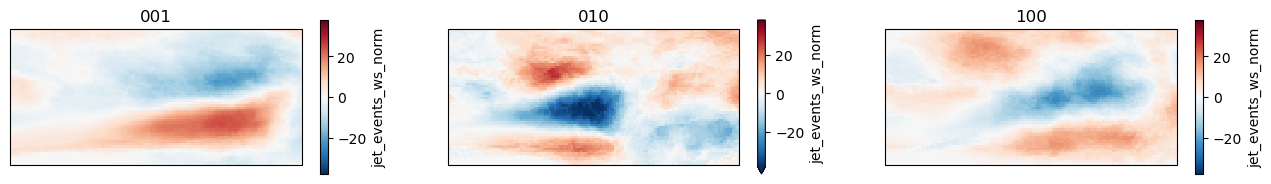

1


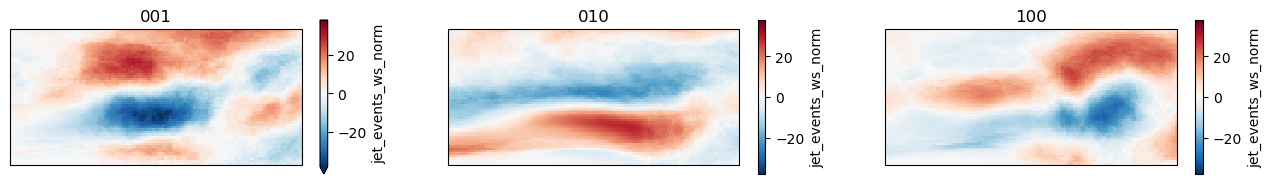

2


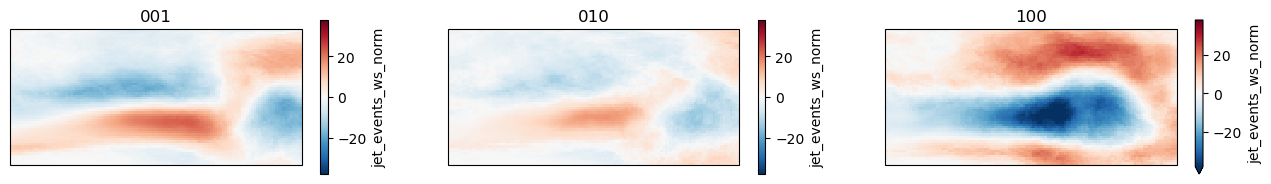

3


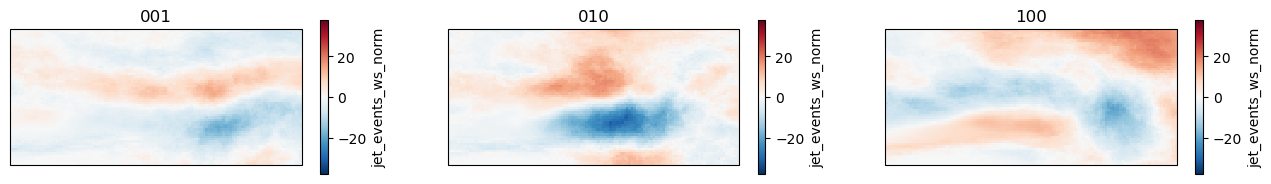

In [39]:
proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)
for lab_num in range(0, n_clusters):
    print(lab_num)
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True, sharex=True, subplot_kw={'projection':proj})
    k06_my_persist_cluster_001 = k06_my_persist_001.sel(time=k06_my_persist_001.time[labels_001 == lab_num])['jet_events_ws_norm']
    k06_my_persist_cluster_mean_001 = k06_my_persist_cluster_001.mean('time')
    
    k06_my_persist_cluster_010 = k06_my_persist_010.sel(time=k06_my_persist_010.time[labels_010 == lab_num])['jet_events_ws_norm']
    k06_my_persist_cluster_mean_010 = k06_my_persist_cluster_010.mean('time')
    
    k06_my_persist_cluster_100 = k06_my_persist_100.sel(time=k06_my_persist_100.time[labels_100 == lab_num])['jet_events_ws_norm']
    k06_my_persist_cluster_mean_100 = k06_my_persist_cluster_100.mean('time')
    k06_my_persist_cluster_mean_001.plot(ax=axes[0], transform=box_proj, vmin=-38, vmax=38, cmap='RdBu_r', cbar_kwargs={'shrink':0.5})
    k06_my_persist_cluster_mean_010.plot(ax=axes[1], transform=box_proj, vmin=-38, vmax=38, cmap='RdBu_r', cbar_kwargs={'shrink':0.5})
    k06_my_persist_cluster_mean_100.plot(ax=axes[2], transform=box_proj, vmin=-38, vmax=38, cmap='RdBu_r', cbar_kwargs={'shrink':0.5})
    axes[0].set_title('001')
    axes[1].set_title('010')
    axes[2].set_title('100')
    plt.show()

In [40]:
coslat = np.cos(np.deg2rad(k06_my_persist_001.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

In [41]:
k06_all_DJF = k06.sel(lon=slice(120,240), lat=slice(15, 70)).sel(time=k06.time.dt.season.isin(['DJF']))

In [42]:
%%time
jet_eof_all = eofs.xarray.Eof(k06_all_DJF[var_to_use], weights=wgts)


CPU times: user 31min 22s, sys: 4.24 s, total: 31min 26s
Wall time: 3min 1s


In [43]:
jet_eof_001 = eofs.xarray.Eof(k06_my_persist_001[var_to_use], weights=wgts)
jet_eof_010 = eofs.xarray.Eof(k06_my_persist_010[var_to_use], weights=wgts)
jet_eof_100 = eofs.xarray.Eof(k06_my_persist_100[var_to_use], weights=wgts)

In [44]:
jet_varfrac_all = jet_eof_all.varianceFraction()
jet_lambdas_all = jet_eof_all.eigenvalues()

jet_varfrac_001 = jet_eof_001.varianceFraction()
jet_lambdas_001 = jet_eof_001.eigenvalues()

jet_varfrac_010 = jet_eof_010.varianceFraction()
jet_lambdas_010 = jet_eof_010.eigenvalues()

jet_varfrac_100 = jet_eof_100.varianceFraction()
jet_lambdas_100 = jet_eof_100.eigenvalues()

In [45]:
jet_eof_vals = jet_eof_all.eofs(neofs=10)

jet_eof_vals_001 = jet_eof_001.eofs(neofs=10)
jet_eof_vals_010 = jet_eof_010.eofs(neofs=10)
jet_eof_vals_100 = jet_eof_100.eofs(neofs=10)

In [46]:
pcs_all = jet_eof_all.pcs(pcscaling=1, npcs=4)


In [47]:
# # flip back so it looks like Winters et al. (2019) result

if pcs_all.sel(mode=0)[0] > 0:
    print('mode 0 wrong way round')
    pcs_all = pcs_all.where((pcs_all.mode != 0), pcs_all.sel(mode=0)*-1)

if pcs_all.sel(mode=1)[0] > 0:
    print('mode 1 wrong way round')
    pcs_all = pcs_all.where((pcs_all.mode != 1), pcs_all.sel(mode=1)*-1)

mode 0 wrong way round
mode 1 wrong way round


<Axes: >

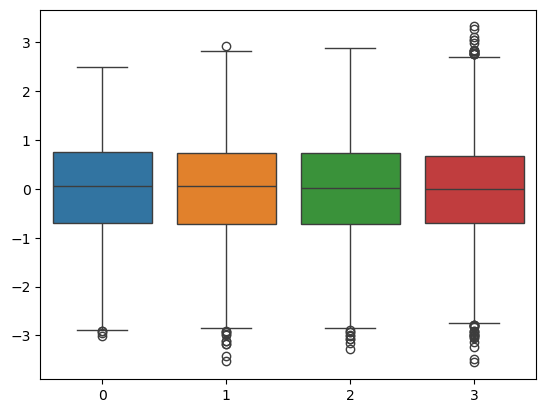

In [48]:
sns.boxplot(pcs_all)

In [49]:
pcs_010 = jet_eof_010.pcs(pcscaling=1, npcs=3)
pcs_100 = jet_eof_100.pcs(pcscaling=1, npcs=3)

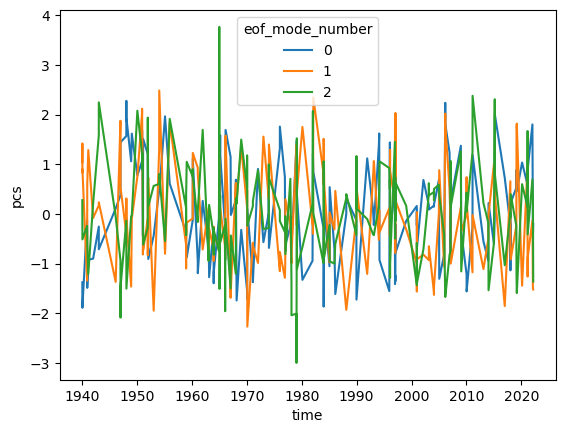

In [50]:
plt.figure()
l = pcs_010.plot.line(x='time')

In [51]:
set2_cmap = sns.color_palette("Set2", 4)
set2_cmap

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

In [52]:
djf_mean = k06['weighted_average_ws'].sel(time=k06.time.dt.season.isin(['DJF'])).mean('time')


In [53]:
# (djf_mean * current_mode).plot()

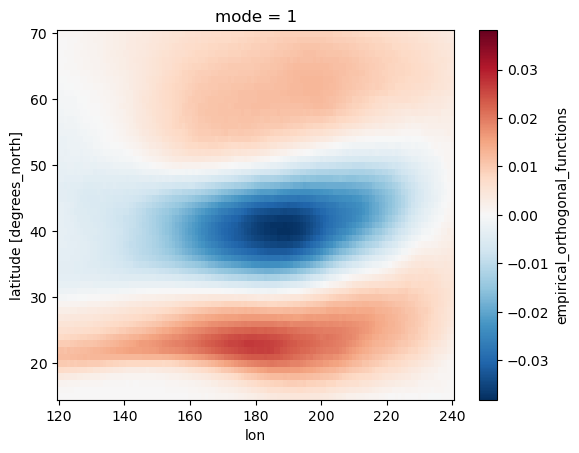

In [54]:
jet_eof_vals.sel(mode=1).plot()

In [55]:
# flip back so it looks like Winters et al. (2019) result

if jet_eof_vals.sel(mode=0).sel(lon=slice(170, 190), lat=slice(40, 50)).mean() > 0:
    print('mode 0 wrong way round')
    jet_eof_vals = jet_eof_vals.where((jet_eof_vals.mode != 0), jet_eof_vals.sel(mode=0)*-1)
        
if jet_eof_vals.sel(mode=1).sel(lon=slice(170, 190), lat=slice(40, 50)).mean() < 0:
    print('mode 1 wrong way round')
    jet_eof_vals = jet_eof_vals.where((jet_eof_vals.mode != 1), jet_eof_vals.sel(mode=1)*-1)

mode 0 wrong way round
mode 1 wrong way round


Text(0.5, 0.98, 'North Pacific jet modes')

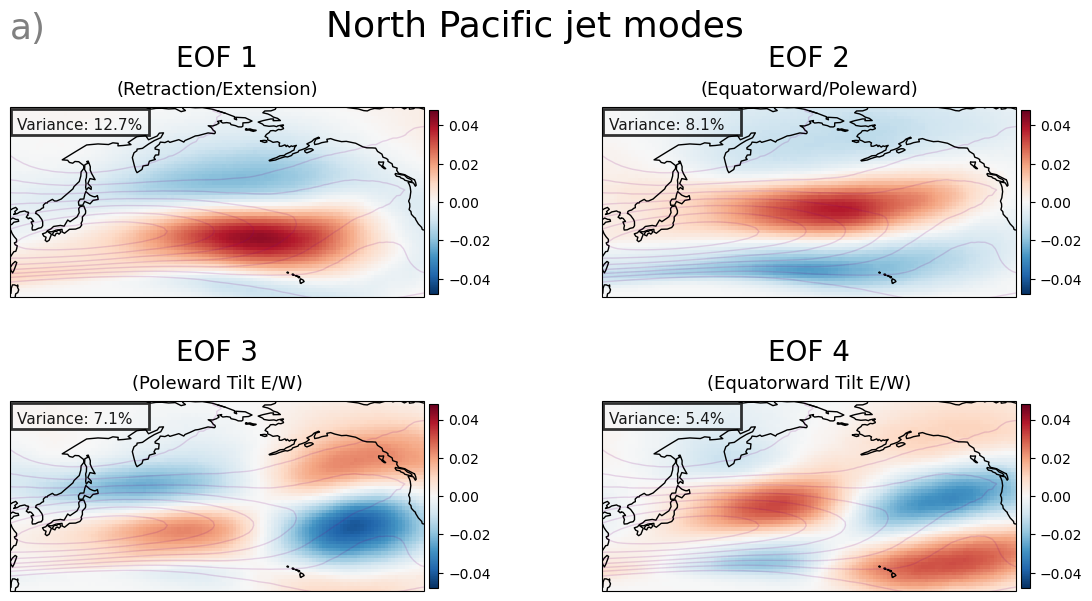

In [56]:
proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)
modes_to_plot = 4
fig, axes = plt.subplots(2, 2, figsize=(14, 7), subplot_kw={'projection':proj})
mps = r"($ms^{-1}$)"
name_of_EOF = ["(Retraction/Extension)", "(Equatorward/Poleward)", "(Poleward Tilt E/W)", "(Equatorward Tilt E/W)"]

for ax_ind, ax in enumerate(axes.flatten()):
    current_mode = jet_eof_vals.sel(mode=ax_ind).copy()
    current_mode.plot(ax=ax, transform=box_proj, center=0, vmin=-0.048, vmax=0.048, cmap='RdBu_r', add_colorbar=True, cbar_kwargs={'shrink': 0.75, 'pad':.01, 'orientation':'vertical', 'label':None})
    ax.coastlines()
    djf_mean.plot.contour(colors='purple', transform=box_proj, levels=np.arange(0, 80, 10), linewidths=1, ax=ax, alpha=.15)
    ax.set_title(f"EOF {ax_ind+1}\n", size=20)
    ax.text(s=f"{name_of_EOF[ax_ind]}", x=0, y=75, size=13, ha='center', va='center')
    # a.text(s=f'Variance: {all_jet_varfracs[ind][ax_ind].values*100:.1f}%', x=-56, y=16, c='k', alpha=.9, size=12)
    ax.text(s=f'Variance: {jet_varfrac_all[ax_ind].values*100:.1f}%', x=-58, y=63.5, c='k', alpha=.9, size=11)
    var_rect = mpatches.Rectangle((-59.6, 62), 40, 7.6, linewidth=2, edgecolor='k', facecolor='none', alpha=.8)
    # var_rect_lower = mpatches.Rectangle((-57, 12), 61, 10, linewidth=1, edgecolor='k', facecolor='none', alpha=.8)
    ax.add_patch(var_rect)
    ax.set_extent([lon_range.start, lon_range.stop, 15, 70], crs=box_proj)
    ax.set_ylabel(f'Mode: {ax_ind}', size=20)

# axes[0][0].set_title(f'0-0-1 (n={219})', color=set2_cmap[3], size=16)
# axes[0][1].set_title(f'0-1-0 (n={146})', color=set2_cmap[2], size=16)
# axes[0][2].set_title(f'1-0-0 (n={132})', color=set2_cmap[1], size=16)
axes[0][0].text(s="a)", x=-60, y=90, c='grey', size=26)

fig.suptitle("North Pacific jet modes", size=26)
# fig.subplots_adjust(wspace=0.15, hspace=0.05)
# fig.savefig('figures/EOF_jetevents_norm_comparison_NPAC_all_names.png', bbox_inches='tight', dpi=300)

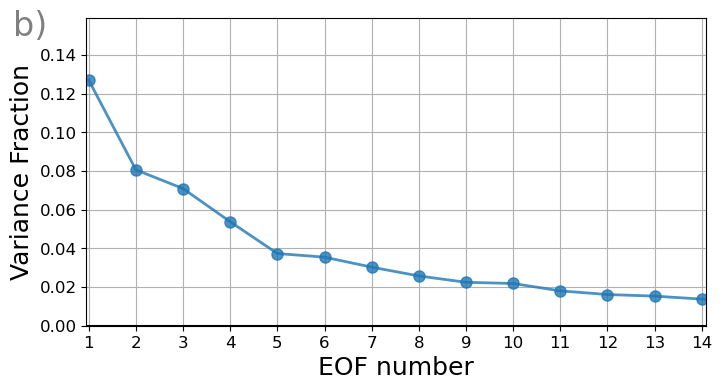

In [57]:
plt.figure(figsize=(8,4))
eof_num = range(1, 26)
plt.plot(eof_num, jet_varfrac_all[0:25], linewidth=2, color='C0', alpha=.8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
# plt.title('Fraction of the total variance represented by each EOF', size=14)
plt.xlabel('EOF number', size=18)
plt.ylabel('Variance Fraction', size=18)
plt.xlim(0.95, 14.1)
plt.ylim(np.min(jet_varfrac_010), np.max(jet_varfrac_010)+0.01)
# plt.legend(['0-0-1', '0-1-0', '1-0-0'], fontsize=14, title_fontsize=14, title='Event Type')
# plt.legend(['0-0-1 (n=219)', '0-1-0 (n=146)', '1-0-0 (n=132)'], fontsize=14, title_fontsize=14, title='Event Type')
plt.plot(eof_num, jet_varfrac_all[0:25], linestyle='None', marker="o", color='C0', markersize=8, alpha=.8)
plt.text(s="b)", x=-0.6, y=0.15, c='grey', size=24)
plt.grid(axis='both')
plt.xticks(size=12);
plt.yticks(size=12);
# plt.savefig('figures/eof_fraction_variance_allcodes_jeteventsnorm_NPAC_all.png', bbox_inches='tight', dpi=300)

In [58]:
pcs_all_df = pcs_all.to_dataframe()
pcs_all_df = pcs_all_df.drop('month', axis=1)
pcs_all_df = pcs_all_df.unstack()
pcs_all_df = pcs_all_df['pcs']

In [59]:
coldaircode_df = extreme_cold_persist_thresh['cold_air_event_stacked_names'].to_dataframe().drop(['dayofyear', 'quantile'], axis=1)

In [60]:
coldaircode_pcs_df = coldaircode_df.merge(pcs_all_df, on='time')

In [61]:
coldaircode_pcs_df = coldaircode_pcs_df.dropna(subset=[0])

In [86]:
coldaircode_pcs_df = coldaircode_pcs_df.loc["1950":]

In [87]:
coldaircode_pcs_df_melt = coldaircode_pcs_df.melt(id_vars=['cold_air_event_stacked_names'], value_vars=[0, 1, 2, 3],
                 var_name='Mode', value_name='Value')

coldaircode_pcs_df_melt['Mode'] = coldaircode_pcs_df_melt['Mode'].astype(str)

In [88]:
color_pallete_to_use = ['#D3D3D3']
color_pallete_to_use.extend(sns.color_palette("Set2", 7)[1:5])
color_pallete_to_use.extend(sns.color_palette("Set2", 7)[0:1])
color_pallete_to_use.extend(sns.color_palette("Set2", 7)[6:7])

In [89]:
def cluster_count(data, season='annual'):
    clustered_count = {}
    if season != 'annual':
        data = data.sel(time=data.time.dt.season.isin([season]))
    for event_code in np.unique(data['cold_air_event_stacked_names']):
        onetype_coldair_event = data.where((data['cold_air_event_stacked_names'] == event_code)\
                                                    ).dropna(dim='time')
        clustered_count[int(str(event_code)[0]), int(str(event_code)[1]), int(str(event_code)[2])] = len(cluster_datetimes(onetype_coldair_event.time))
    return clustered_count

In [90]:
%%time
clustered_count_djf = cluster_count(extreme_cold_persist_thresh.sel(time=slice("1950", "2023-03")), season='DJF')

CPU times: user 20.9 s, sys: 442 ms, total: 21.3 s
Wall time: 21.4 s


In [91]:
clustered_count_djf

{(0, 0, 0): 420,
 (0, 0, 1): 202,
 (0, 1, 0): 132,
 (0, 1, 1): 45,
 (1, 0, 0): 105,
 (1, 1, 0): 62,
 (1, 1, 1): 7}

In [92]:
labels

['100', '010', '001', '110', '011', '111']

/tmp/ipykernel_33502/3587166355.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels(['EOF 1 \n(Retraction/               )', 'EOF 2 \n(Equatorward/              )', 'EOF 3 \n(Poleward Tilt E/   )', 'EOF 4 \n(Equatorward Tilt E/   )'])


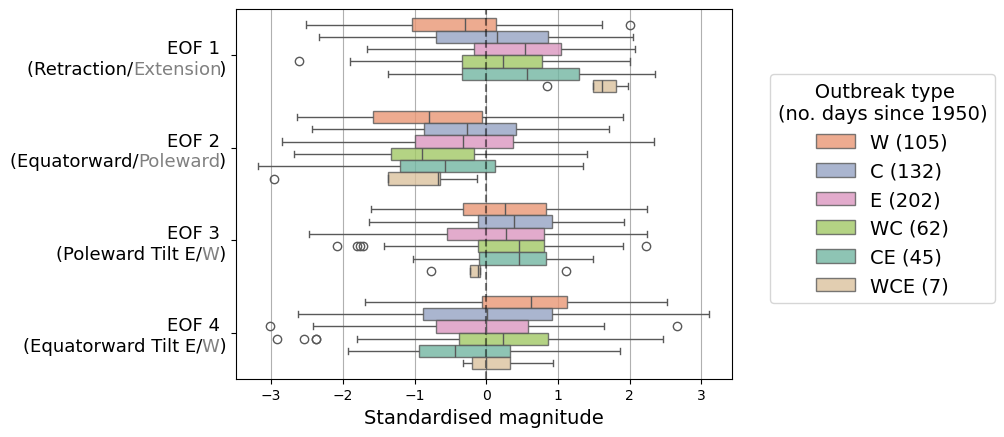

In [100]:
fig, axes = plt.subplots(1)
box1 = sns.boxplot(x='Value', y='Mode', hue='cold_air_event_stacked_names',\
            hue_order=['100', '010', '001', '110', '011', '111'],\
            ax=axes, boxprops=dict(alpha=.8), palette=color_pallete_to_use[1:],\
            data=coldaircode_pcs_df_melt.loc[coldaircode_pcs_df_melt['cold_air_event_stacked_names'] != '000'].dropna())

box1.get_legend().remove()

handles, labels = box1.get_legend_handles_labels()
new_code_labels = ['W', 'C', 'E', 'WC', 'CE', 'WCE']
new_labels = []
for ind, lab in enumerate(labels):
    new_lab = f"{new_code_labels[ind]} ({clustered_count_djf[int(lab[0]), int(lab[1]), int(lab[2])]})"
    new_labels.append(new_lab)
axes.legend(handles, new_labels, title="      Outbreak type \n(no. days since 1950)", title_fontsize=14, fontsize=14,\
            ncols=1, loc=0, bbox_to_anchor=(1.05, 0.35, 0.5, 0.5))

# axes.set_title("North Pacific jet modes", size=19)

axes.axvline(linestyle='--', color='k', alpha=0.5)
axes.grid(axis='x')
axes.set_ylabel("", size=12) # 'Climate Index'
axes.set_xlabel("Standardised magnitude", size=14)
axes.set_yticklabels(['EOF 1 \n(Retraction/               )', 'EOF 2 \n(Equatorward/              )', 'EOF 3 \n(Poleward Tilt E/   )', 'EOF 4 \n(Equatorward Tilt E/   )'])
axes.text(s='Extension', x=-4.93, y=0.2, size=13, c='grey')
axes.text(s='Poleward', x=-4.85, y=1.2, size=13, c='grey')
axes.text(s='W', x=-3.97, y=2.205, size=13, c='grey')
axes.text(s='W', x=-3.97, y=3.205, size=13, c='grey')
axes.set_yticks(axes.get_yticks(), axes.get_yticklabels(), size=13)
plt.subplots_adjust(wspace=.1)

# fig.savefig('figures/EOF_byevent_boxplots.png', bbox_inches='tight', dpi=300)

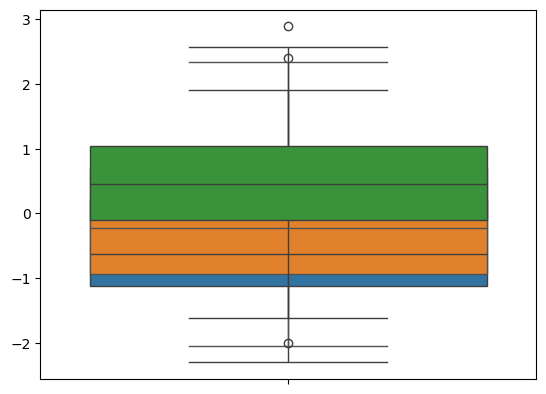

In [65]:
for cold_event_code in ['001', '010', '100']:
    onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == cold_event_code)\
                                            ).dropna(dim='time')
    onetype_coldair_event = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin(['DJF']))
    pcs_oneevent = pcs_all.sel(time=onetype_coldair_event.time)
    sns.boxplot(pcs_oneevent.sel(mode=0))

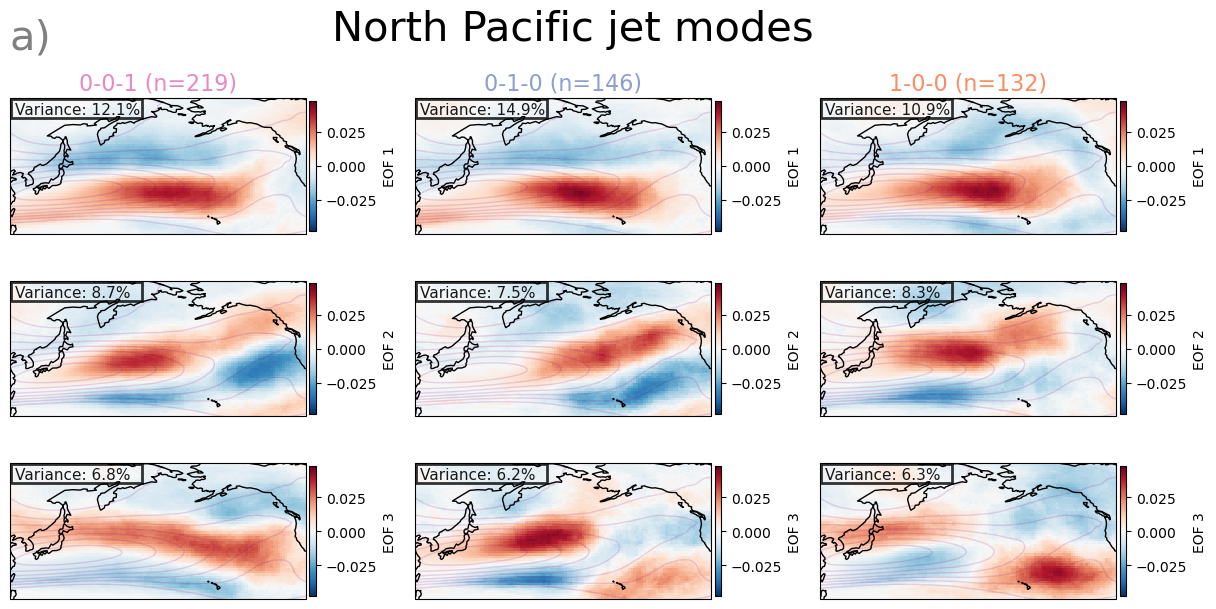

In [66]:
proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig, axes = plt.subplots(3, 3, figsize=(15, 7), subplot_kw={'projection':proj})
mps = r"($ms^{-1}$)"
all_jet_eofs = [jet_eof_vals_001, jet_eof_vals_010, jet_eof_vals_100]
all_jet_varfracs = [jet_varfrac_001, jet_varfrac_010, jet_varfrac_100]


for ax_ind, ax in enumerate(axes):
    for ind, a in enumerate(ax):
        current_mode = all_jet_eofs[ind].sel(mode=ax_ind).copy()
        if current_mode.sel(lon=slice(170, 190), lat=slice(40, 50)).mean() < 0:
            current_mode *= -1
        if ax_ind == 0:
            # flip back so it looks like Winters et al. (2019) result
            current_mode *= -1
        current_mode.plot(ax=a, transform=box_proj, center=0, vmin=-0.048, vmax=0.048, cmap='RdBu_r', add_colorbar=True, cbar_kwargs={'shrink': 0.75, 'pad':.01, 'orientation':'vertical', 'label': f'EOF {ax_ind+1}'})
        a.coastlines()
        djf_mean.plot.contour(colors='purple', transform=box_proj, levels=np.arange(0, 80, 10), linewidths=1, ax=a, alpha=.15)
        a.set_title(None)
        a.set_ylabel("001")
        # a.text(s=f'Variance: {all_jet_varfracs[ind][ax_ind].values*100:.1f}%', x=-56, y=16, c='k', alpha=.9, size=12)
        a.text(s=f'Variance: {all_jet_varfracs[ind][ax_ind].values*100:.1f}%', x=-58, y=63.5, c='k', alpha=.9, size=11)
        var_rect = mpatches.Rectangle((-59.6, 62), 53, 7.6, linewidth=2, edgecolor='k', facecolor='none', alpha=.8)
        # var_rect_lower = mpatches.Rectangle((-57, 12), 61, 10, linewidth=1, edgecolor='k', facecolor='none', alpha=.8)
        a.add_patch(var_rect)
        a.set_extent([lon_range.start, lon_range.stop, 15, 70], crs=box_proj)
    ax[0].set_ylabel(f'Mode: {ax_ind}', size=20)

axes[0][0].set_title(f'0-0-1 (n={219})', color=set2_cmap[3], size=16)
axes[0][1].set_title(f'0-1-0 (n={146})', color=set2_cmap[2], size=16)
axes[0][2].set_title(f'1-0-0 (n={132})', color=set2_cmap[1], size=16)
axes[0][0].text(s="a)", x=-60, y=90, c='grey', size=30)

fig.suptitle("North Pacific jet modes", size=30)
fig.subplots_adjust(wspace=0.15, hspace=0.05)
# fig.savefig('figures/EOF_jetevents_norm_comparison_NPAC.png', bbox_inches='tight', dpi=300)

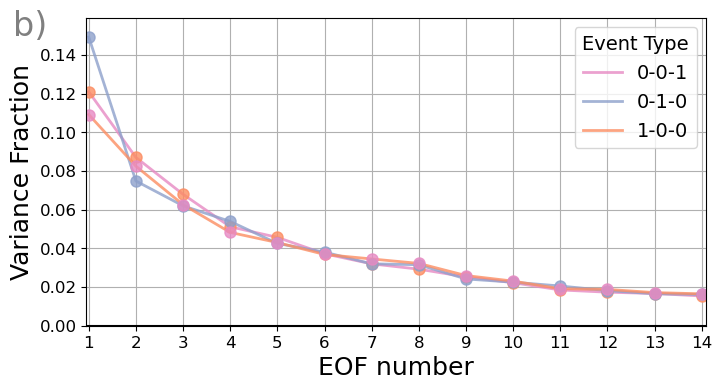

In [67]:
plt.figure(figsize=(8,4))
eof_num = range(1, 26)
plt.plot(eof_num, jet_varfrac_001[0:25], linewidth=2, color=set2_cmap[3], alpha=.8)
plt.plot(eof_num, jet_varfrac_010[0:25], linewidth=2, color=set2_cmap[2], alpha=.8)
plt.plot(eof_num, jet_varfrac_100[0:25], linewidth=2, color=set2_cmap[1], alpha=.8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
# plt.title('Fraction of the total variance represented by each EOF', size=14)
plt.xlabel('EOF number', size=18)
plt.ylabel('Variance Fraction', size=18)
plt.xlim(0.95, 14.1)
plt.ylim(np.min(jet_varfrac_010), np.max(jet_varfrac_010)+0.01)
plt.legend(['0-0-1', '0-1-0', '1-0-0'], fontsize=14, title_fontsize=14, title='Event Type')
# plt.legend(['0-0-1 (n=219)', '0-1-0 (n=146)', '1-0-0 (n=132)'], fontsize=14, title_fontsize=14, title='Event Type')
plt.plot(eof_num, jet_varfrac_001[0:25], linestyle='None', marker="o", color=set2_cmap[1], markersize=8, alpha=.8)
plt.plot(eof_num, jet_varfrac_010[0:25], linestyle='None', marker="o", color=set2_cmap[2], markersize=8, alpha=.8)
plt.plot(eof_num, jet_varfrac_100[0:25], linestyle='None', marker="o", color=set2_cmap[3], markersize=8, alpha=.8)
plt.text(s="b)", x=-0.6, y=0.15, c='grey', size=24)
plt.grid(axis='both')
plt.xticks(size=12);
plt.yticks(size=12);
# plt.savefig('figures/eof_fraction_variance_allcodes_jeteventsnorm_NPAC.png', bbox_inches='tight', dpi=300)